# Import des librairies et initialisation de RayLib

In [1]:
from ray.rllib.algorithms.ppo import PPOConfig
from ray.rllib.policy.policy import PolicySpec
from minigrid.wrappers import ImgObsWrapper
# from multigrid.rllib import RLlibWrapper

# import multigrid.envs
# from multigrid.base import MultiGridEnv
from ray.rllib.env import MultiAgentEnv
import gymnasium as gym
import ray
from ray.tune.registry import register_env
import matplotlib.pyplot as plt
import numpy as np
import torch
from gymnasium.wrappers import RecordEpisodeStatistics, RecordVideo
from gymnasium.spaces import Box, Dict
import time



if not ray.is_initialized():
    ray.init(ignore_reinit_error=True)


2024-12-18 22:49:20,814	INFO worker.py:1821 -- Started a local Ray instance.


# Single agents environments 

## Minigrid

**Minigrid** est une librairie qui met à disposition des environements de type gridword customisable et jolies, cependant les observations que retourne leur environement n'ont pas le format attendue par l'algo PPO, qui utilise comme Policy un réseaux de neurone et qui attend donc un vecteur plat (flattened) avec des valeurs floats. 

C'est pour ça qu'il a fallut créer un **CustomWrapper**, qui permet d'ajouter une couche à l'environment, convertissant les sorties au bon format (aplatie, float).

J'applique aussi un autre wrapper fournit par minigrid (**ImgObsWrapper**) qui permet de retirer une valeur "mission" des observations retournées. 

In [2]:

import numpy as np

class CustomFlatObsWrapper(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        # Calculer la taille de l'observation aplatie
        flat_obs_dim = np.prod(env.observation_space.shape)
        # Modifier l'espace d'observation
        self.observation_space = gym.spaces.Box(
            low=float(env.observation_space.low.min()),  # Minimum des observations
            high=float(env.observation_space.high.max()),  # Maximum des observations
            shape=(flat_obs_dim,),  # Taille aplatie
            dtype=np.float32,
        )

    def observation(self, obs):
        # Transformer l'observation en un vecteur 1D de type float32
        return obs.flatten().astype(np.float32)


def env_creator(env_config, render_mode=None):
    env = gym.make("MiniGrid-Empty-8x8-v0", render_mode=render_mode)  # Créez l'environnement MiniGrid
    env = ImgObsWrapper(env)  # Retire la mission de l'observation.
    env = CustomFlatObsWrapper(env)  # Appliquez le wrapper pour des observations aplaties
    return env

# Étape 2 : Enregistrer l'environnement avec RLlib
register_env("MiniGrid-FlatObs-8x8-v0", env_creator)



2024-12-18 22:49:21,747	WARNING ppo.py:295 -- You are running PPO on the new API stack! This is the new default behavior for this algorithm. If you don't want to use the new API stack, set `config.api_stack(enable_rl_module_and_learner=False,enable_env_runner_and_connector_v2=False)`. For a detailed migration guide, see here: https://docs.ray.io/en/master/rllib/new-api-stack-migration-guide.html
/home/eldritch/anaconda3/envs/MARL/lib/python3.9/site-packages/ray/rllib/algorithms/algorithm.py:569: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/eldritch/anaconda3/envs/MARL/lib/python3.9/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warnin

(SingleAgentEnvRunner pid=997554) 2024-12-18 22:49:23,968	WARNING deprecation.py:50 -- DeprecationWarning: `RLModule(config=[RLModuleConfig object])` has been deprecated. Use `RLModule(observation_space=.., action_space=.., inference_only=.., model_config=.., catalog_class=..)` instead. This will raise an error in the future!
(SingleAgentEnvRunner pid=997558) /home/eldritch/anaconda3/envs/MARL/lib/python3.9/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
(SingleAgentEnvRunner pid=997558)   gym.logger.warn(
(SingleAgentEnvRunner pid=997558) 2024-12-18 22:49:59,834	WARNING deprecation.py:50 -- DeprecationWarning: `RLModule(config=[RLModuleConfig object])` has been deprecated. Use `RLModule(observation_space=.., action_space=.., inference_only=.., model_config=.., catalog_class=..)` instead. This will raise an error in the future!
(MultiAgentEnvRunner pid=997549) /home/eldritch/anaconda3/envs/MARL/l

Iter: 0, Mean Reward: 0.0
Iter: 1, Mean Reward: 0.0
Iter: 2, Mean Reward: 0.0
Iter: 3, Mean Reward: 0.029873511904761903
Iter: 4, Mean Reward: 0.07783777573529412
Iter: 5, Mean Reward: 0.1307421875
Iter: 6, Mean Reward: 0.21092187499999998
Iter: 7, Mean Reward: 0.28142968749999997
Iter: 8, Mean Reward: 0.4335859375
Iter: 9, Mean Reward: 0.5178242187500001
Iter: 10, Mean Reward: 0.59858203125
Iter: 11, Mean Reward: 0.6673203125
Iter: 12, Mean Reward: 0.6917539062500001
Iter: 13, Mean Reward: 0.7341445312499998
Iter: 14, Mean Reward: 0.83480078125
Iter: 15, Mean Reward: 0.88099609375
Iter: 16, Mean Reward: 0.9001210937499999
Iter: 17, Mean Reward: 0.9079257812499998
Iter: 18, Mean Reward: 0.9165039062499999
Iter: 19, Mean Reward: 0.916890625
Iter: 20, Mean Reward: 0.9225156250000001
Iter: 21, Mean Reward: 0.92241015625
Iter: 22, Mean Reward: 0.9270859375000002
Iter: 23, Mean Reward: 0.9295468750000001
Iter: 24, Mean Reward: 0.9355937499999999


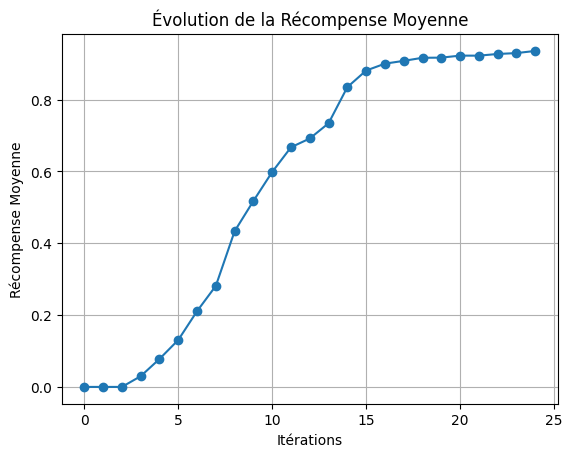

In [3]:


config = (
    PPOConfig()
    .environment(env="MiniGrid-FlatObs-8x8-v0")
    .training(train_batch_size=600)
    .api_stack(
        enable_rl_module_and_learner=True,
        enable_env_runner_and_connector_v2=True,
    )
    # .framework("torch")

)

mean_returns = []
algo = config.build()
for i in range(25):
    result = algo.train()
    # Vérifiez les clés disponibles dans result si 'episode_reward_mean' n'y figure pas.
    mean_return = result["env_runners"]["agent_episode_returns_mean"]["default_agent"]
    mean_returns.append(mean_return)
    
    print(f"Iter: {i}, Mean Reward: {mean_return}")

# Tracer les résultats
plt.plot(range(len(mean_returns)), mean_returns, marker="o")
plt.xlabel("Itérations")
plt.ylabel("Récompense Moyenne")
plt.title("Évolution de la Récompense Moyenne")
plt.grid()
plt.show()

In [4]:
!pip install "gymnasium[other]"

In [5]:

# Créez une instance de l'environnement
test_env = env_creator({}, render_mode="rgb_array")  # Utilisez "rgb_array" pour le rendu vidéo

# Ajoutez les wrappers
video_trigger = lambda episode_id: episode_id % 1 == 0  # Enregistrer une vidéo pour chaque épisode
test_env = RecordVideo(test_env, video_folder="videos/", episode_trigger=video_trigger)  # Vidéo par épisode
test_env = RecordEpisodeStatistics(test_env)  # Enregistre les statistiques

rl_module = algo.get_module("default_policy")

episode_return = 0
terminated = truncated = False

# Réinitialisation de l'environnement
obs, info = test_env.reset()

while not terminated and not truncated:
    # Compute the next action from a batch (B=1) of observations
    torch_obs_batch = torch.from_numpy(np.array([obs]))
    action_logits = rl_module.forward_inference({"obs": torch_obs_batch})[
        "action_dist_inputs"
    ]
    # The default RLModule used here produces action logits (from which
    # we'll have to sample an action or use the max-likelihood one).
    action = int(torch.argmax(action_logits[0]).numpy())
    obs, reward, terminated, truncated, info = test_env.step(action)
    episode_return += reward
    print(reward, action, terminated, truncated)

    # Optionnel : Afficher les statistiques de l'épisode
    if "episode" in info.keys():
        print(f"Episode stats: {info['episode']}")

test_env.close()

print(f"Reached episode return of {episode_return}.")


/home/eldritch/anaconda3/envs/MARL/lib/python3.9/site-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /mnt/c/Users/romai/OneDrive/Documents/Poly/Maitrise Automne 2024/INF8450AE - Reinforcement Learning/Project/code/Multi_Agent_Reinforcement_Learning/videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


0 1 False False
0 2 False False
0 2 False False
0 2 False False
0 2 False False
0 2 False False
0 0 False False
0 2 False False
0 2 False False
0 2 False False
0 2 False False
0.9578125 2 True False
Episode stats: {'r': 0.9578125, 'l': 12, 't': 0.168735}
Reached episode return of 0.9578125.


In [6]:
test_env.close()


## My environment

Un exemple d'entrainement et de test d'agents sur un environement **gridword single agent basique** (le joueur doit atteindre la cible). Cet exemple permet de comprendre comment :
* **créer un environnement** avec RLlib
* **utiliser** cet environnement
* **initialiser** un agent 
* **entrainer** un agent sur cet environnement
* **Tester** l'agent entrainer
* **Visualiser** les résultats


### 1. Enrgistrer l'environnement

Une fois que l'environnement a été créer (classe séparée), il faut **l'enrigistrer dans le répertoire RLlib**, pour qu'il soit accessible facilement par les agents (qu'on initialisera plus tard) à l'aide d'un **identifiant (string)**

In [7]:
from multi_agents_envs.centralized_multi_agent_env import CentralizedAgentGridWorldEnv as GridWorldEnv

def env_creator(env_config):
    return GridWorldEnv(env_config)

register_env("GridWorldEnv", env_creator)

### 2. Initialisation de l'agent 

Tous les agents appartiennent à la classe algorithme, qui va contenir plusieurs modules :

* **RLModule** : Contient la politique (souvent un réseau de neurones), avec les fonctions pour prendre une action en fonction de l'observation. C'est ici que la logique d'inférence et d'apprentissage des actions est définie.
* **Policy** : Définit les règles ou stratégies utilisées par l'agent pour prendre des décisions. Cela inclut le modèle, les distributions d'actions (comme action_dist_inputs) et les méthodes pour l'entraînement et l'évaluation de la politique.
* **Trainer** : Responsable de l'entraînement des politiques. Il utilise l'algorithme de RL spécifié (par exemple PPO, DQN) pour mettre à jour les paramètres des RLModules.
* **RolloutWorker** (parfois appelé env_runer): une duplication de l'agent, qui va servir à collecter les données (transitions) par batch de taille fixe, les transmettre à l'agent principale, qui lui les utilisera pour mettre à jour les poids du modèle.
* **AlgorithmConfig** : En gros les paramètres de l'algorithme (nombre d'agents, type d'algorithme (PO, DQN..), paramètres du modèle, configuration de l'environnement, etc.).


In [8]:
# Ici par exemple on créer une configuration de l'algorithme PPO avec des paramètres spécifiques
config = (
    PPOConfig()  # Utilisation de l'algorithme PPO 
    .environment(env="GridWorldEnv", env_config={"size": 5, "max_steps": 800})  # On spécifie l'environnement à utiliser (celui enregistré auparavant)
    .training(train_batch_size_per_learner=4000)  
    .api_stack(  
        enable_rl_module_and_learner=True, 
        enable_env_runner_and_connector_v2=True,  
    )
    .framework("torch")  # Utilisation de PyTorch comme backend pour le modèle
)

# Initialisation de l'algorithme PPO à partir de la configuration
algo = config.build()



2024-12-18 22:49:57,569	WARNING ppo.py:295 -- You are running PPO on the new API stack! This is the new default behavior for this algorithm. If you don't want to use the new API stack, set `config.api_stack(enable_rl_module_and_learner=False,enable_env_runner_and_connector_v2=False)`. For a detailed migration guide, see here: https://docs.ray.io/en/master/rllib/new-api-stack-migration-guide.html
/home/eldritch/anaconda3/envs/MARL/lib/python3.9/site-packages/ray/rllib/algorithms/algorithm.py:569: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/eldritch/anaconda3/envs/MARL/lib/python3.9/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warnin

### 3. Boucle d'entrainement

Iter: 0, Mean Reward: 208.52631578947367
Iter: 1, Mean Reward: 234.96774193548387
Iter: 2, Mean Reward: 251.365
Iter: 3, Mean Reward: 256.15
Iter: 4, Mean Reward: 266.49
Iter: 5, Mean Reward: 269.7
Iter: 6, Mean Reward: 284.04
Iter: 7, Mean Reward: 286.56
Iter: 8, Mean Reward: 297.58
Iter: 9, Mean Reward: 308.82
Iter: 10, Mean Reward: 336.22
Iter: 11, Mean Reward: 340.14
Iter: 12, Mean Reward: 349.65
Iter: 13, Mean Reward: 353.42
Iter: 14, Mean Reward: 360.44
Iter: 15, Mean Reward: 370.31
Iter: 16, Mean Reward: 369.18
Iter: 17, Mean Reward: 373.21
Iter: 18, Mean Reward: 380.21
Iter: 19, Mean Reward: 380.89


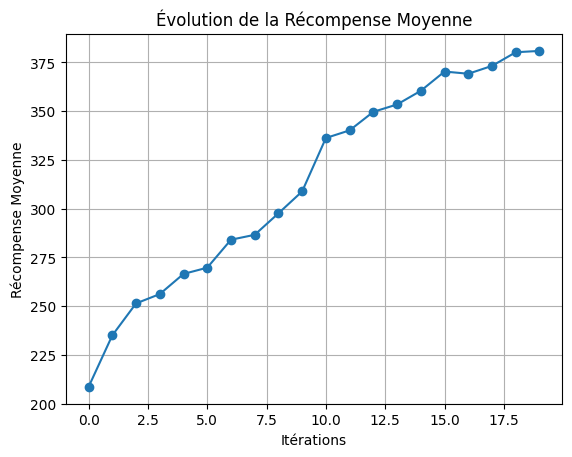

In [9]:
mean_returns = []


for i in range(20):
    result = algo.train()  # Entraîner l'algorithme sur une itération

    # Extraction de la récompense moyenne pour l'agent "default_agent"
    mean_return = result["env_runners"]["agent_episode_returns_mean"]["default_agent"]
    mean_returns.append(mean_return)  

    print(f"Iter: {i}, Mean Reward: {mean_return}")

plt.plot(range(len(mean_returns)), mean_returns, marker="o")
plt.xlabel("Itérations")
plt.ylabel("Récompense Moyenne")
plt.title("Évolution de la Récompense Moyenne")
plt.grid()
plt.show()


### 4. Tester l'agent entrainer 

Il faut : 
* **Initialiser un nouvel environnement** pour tester l'agent entrainé dessus 
* **Récupérer la policy** de l'agent entrainé pour pouvoir effectuer des actions
* **répéter** jusqu'à ce que l'épisode soit terminé

In [10]:
import torch
import numpy as np

# Initialisation de l'environnement d'évaluation
eval_env = GridWorldEnv({"size": 5, "max_steps": 800})

# On récupère la politique directement du RLModule
rl_module = algo.get_module("default_policy")

# Variables pour suivre l'épisode
episode_return = 0
terminated = truncated = False
obs, info = eval_env.reset()

# Boucle d'évaluation : exécute l'agent dans l'environnement jusqu'à la fin de l'épisode
while not terminated and not truncated:
    # Calcul de l'action à partir de l'observation (via le module RL)
    torch_obs_batch = torch.from_numpy(np.array([obs]))
    action_logits = rl_module.forward_inference({"obs": torch_obs_batch})["action_dist_inputs"]
    action = int(torch.argmax(action_logits[0]).numpy())  # Action maximale (greedy)

    # Exécution de l'action dans l'environnement
    obs, reward, terminated, truncated, info = eval_env.step(action)
    episode_return += reward
    print(reward, action, terminated, truncated) 

# Affichage du retour total atteint dans l'épisode
print(f"Reached episode return of {episode_return}.")


4 6 False False
4 15 False False
4 7 False False
-2 7 False False
-2 7 False False
-2 11 False False
-2 11 False False
-2 11 False False
-2 11 False False
-2 11 False False
-2 11 False False
-2 11 False False
-2 11 False False
-2 11 False False
-2 11 False False
-2 11 False False
-2 11 False False
-2 11 False False
-2 11 False False
-2 11 False False
-2 11 False False
-2 11 False False
-2 11 False False
-2 11 False False
-2 11 False False
-2 11 False False
-2 11 False False
-2 11 False False
-2 11 False False
-2 11 False False
-2 11 False False
-2 11 False False
-2 11 False False
-2 11 False False
-2 11 False False
-2 11 False False
-2 11 False False
-2 11 False False
-2 11 False False
-2 11 False False
-2 11 False False
-2 11 False False
-2 11 False False
-2 11 False False
-2 11 False False
-2 11 False False
-2 11 False False
-2 11 False False
-2 11 False False
-2 11 False False
-2 11 False False
-2 11 False False
-2 11 False False
-2 11 False False
-2 11 False False
-2 11 False False

/home/eldritch/anaconda3/envs/MARL/lib/python3.9/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(


# Multi-agents environments 

## My Multi Agent Env

Pour entrainer plusieurs agents sur le même environnement, il faut d'abord adapter l'environnement (voir classe NewMultiAgentEnv). C'est le plus gros du travail, ensuite il faut simplement :
* Créer un algo comme pour le single agent env 
* Lui spécifier comment gérer plusieurs agents via le callback **multiagent** 

### 1. Mapping Agent ==> Policy

Dans un environnement multi agent, chaque personable jouable à un identifiant (souvent "agent_1", "agent_2"...). D'un autre côté, les algorithmes qui contiennet les policies (donc les joueurs/agents que l'on entraine) ont aussi un identifiant. Il faut donc, pour s'assurer que les actions d'un joueur soient toujours prit par la même policy, définir une fonction qui map une policy à son joueur. 

La fonction ***policy_mapping_fn*** permet faire cela : 

In [11]:
# j'ai nommé les agents et les policies de la même manière, il suffit donc de mapper l'agent "agent_1" à la policy "agent_1" par exemple
def policy_mapping_fn(agent_id, episode=None):
    """
    Maps agent_id to a policy.
    """
    return agent_id  # Retourne le même ID que la politique


In [12]:
#FIRST MARL WORKING BASIC EVIRONMENT

# from multi_agents_envs.my_multi_agent_env import MultiAgentGridWorldEnv

# def multi_agent_env_creator(env_config):
#     return MultiAgentGridWorldEnv(env_config)

# register_env("MultiAgentGridWorldEnv", multi_agent_env_creator)

### 2. Enregistrer l'environnement

Il faut enregistrer l'environnement multi agent dans le répertoire RLlib. 

In [13]:
from multi_agents_envs.history_multi_agent_env import MultiAgentGridWorldEnv

def multi_agent_env_creator(env_config):
    return MultiAgentGridWorldEnv(env_config)

register_env("MultiAgentGridWorldEnv", multi_agent_env_creator)

### 3. Fonctions utilitaires

Ici une fonction pour évaluer un agent entrainé, sur un environement de test. 

* Pour enregistrer une vidéo du test : Choisir ***render_mode="rgb_array*"** et ***record_video=True***
* Pour voir ce qu'il se passe en temps réel sur une fenêtre pygame : choisir ***render_mode="human*"** et ***record_video=False***

Le paramètre ***sleep_time*** permet de réguler la vitesse à laquelle sont prises les actions, afin de ralentir ou accélerer le jeu.

In [14]:
import torch
import numpy as np
import time

def evaluate_algorithm(algo, env_config, render_mode="human", record_video=False, video_folder="videos_multi_agent/", sleep_time=0.01):
    """
    Evaluate an RLlib algorithm on a single episode.

    Args:
        algo: Trained RLlib algorithm instance.
        env_config (dict): Configuration for the evaluation environment.
        render_mode (str): Rendering mode ("human" or "rgb_array").
        record_video (bool): If True, records a video of the evaluation episode.
        video_folder (str): Directory to save recorded videos.

    Returns:
        Tuple: Total rewards for agent_1 and agent_2.
    """

    # Initialize the evaluation environment
    eval_env = MultiAgentGridWorldEnv(env_config={"size": env_config["size"], 
                                                     "max_steps": env_config["max_steps"], 
                                                     "render_mode": render_mode})

    # Optional: Wrap the environment to record a video
    if record_video:
        video_trigger = lambda episode_id: episode_id == 0  # Record only the first episode
        eval_env = RecordVideo(eval_env, video_folder=video_folder, episode_trigger=video_trigger)

    # Access RLModules for the agents
    rl_module_1 = algo.get_module("agent_1")
    rl_module_2 = algo.get_module("agent_2")

    def get_action(rl_module, observation):
        """Compute action for a given RL module and observation."""
        torch_obs_batch = torch.from_numpy(np.array([observation]))
        action_logits = rl_module.forward_inference({"obs": torch_obs_batch})["action_dist_inputs"]
        action = int(torch.argmax(action_logits[0]).numpy())
        return action

    # Episode tracking
    episode_return_1 = 0
    episode_return_2 = 0
    terminated = {"__all__": False}
    truncated = {"__all__": False}

    # Reset the environment
    obs, info = eval_env.reset()

    # Evaluation loop
    while not terminated["__all__"] and not truncated["__all__"]:
        actions = {}
        if "agent_1" in obs:
            actions["agent_1"] = get_action(rl_module_1, obs["agent_1"])
        if "agent_2" in obs:
            actions["agent_2"] = get_action(rl_module_2, obs["agent_2"])

        obs, rewards, terminated, truncated, info = eval_env.step(actions)

        # Update episode returns
        episode_return_1 += rewards.get("agent_1", 0)
        episode_return_2 += rewards.get("agent_2", 0)

        # Print step information
        # print(f"Step Info: Agent 1 Reward = {rewards.get('agent_1', 0)}, Agent 2 Reward = {rewards.get('agent_2', 0)}")

        time.sleep(sleep_time)  # Optional delay for better rendering visualization

    # Close the environment
    eval_env.close()

    # Final episode returns
    print(f"Final Episode Return - Agent 1: {episode_return_1}, Agent 2: {episode_return_2}")

    return episode_return_1, episode_return_2


### 3. Initialisation de l'agent 

Comme expliqué plutôt, la seule différence est qu'on ajoute une option ***multi_agent*** dans la *config* de l'algorithme, qui prend la **politique de chaque agent à entrainer** et la fonction de **mapping définie** plus haut. Chaque agent a sa propre policy, qui est un PPO par défaut étant donné que l'algorithme est un PPO. 

In [15]:
env_config = {
    "size": 5,
    "max_steps": 800,
    "render_mode": "human"  
}

batch_size = 4000   

# Configurer RLlib pour un environnement multi-agent
config = (
    PPOConfig()
    .environment(env="MultiAgentGridWorldEnv", env_config={"size": env_config.get("size"), "max_steps": env_config.get("max_steps")})
    .training(train_batch_size_per_learner=batch_size)
    .api_stack(
        enable_rl_module_and_learner=True,
        enable_env_runner_and_connector_v2=True,
    )
    .framework("torch")
    .multi_agent(
        policies={
            "agent_1": PolicySpec(
                policy_class=None,  # Inférer automatiquement
                observation_space=None,  # Inférer automatiquement depuis l'environnement
                action_space=None,  # Inférer automatiquement depuis l'environnement
                config=None,  # Utiliser la configuration par défaut
            ),
            "agent_2": PolicySpec(
                policy_class=None,  # Inférer automatiquement
                observation_space=None,  # Inférer automatiquement depuis l'environnement
                action_space=None,  # Inférer automatiquement depuis l'environnement
                config=None,  # Utiliser la configuration par défaut
            ),
        },
        policy_mapping_fn=policy_mapping_fn,
    )
)

algo = config.build()


2024-12-18 22:52:16,976	WARNING ppo.py:295 -- You are running PPO on the new API stack! This is the new default behavior for this algorithm. If you don't want to use the new API stack, set `config.api_stack(enable_rl_module_and_learner=False,enable_env_runner_and_connector_v2=False)`. For a detailed migration guide, see here: https://docs.ray.io/en/master/rllib/new-api-stack-migration-guide.html
/home/eldritch/anaconda3/envs/MARL/lib/python3.9/site-packages/ray/rllib/algorithms/algorithm.py:569: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/eldritch/anaconda3/envs/MARL/lib/python3.9/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warnin

### 4. Simple test pour voir si le visuel de l'environnement fonctionne

Le jeu s'ouvre sur une autre fenêtre

In [ ]:
env = MultiAgentGridWorldEnv(env_config)

# Reset the environment
observations, _ = env.reset()

for _ in range(10):  
    
    # Random actions for each agent
    actions = {agent_id: env.action_space[agent_id].sample() for agent_id in env.get_agent_ids()}
    observations, rewards, terminated, truncated, infos = env.step(actions)
    time.sleep(0.5)

    # Check if the episode is done
    if terminated["__all__"] or truncated["__all__"]:
        break

# Close the environment
env.close()


NameError: name 'NewMultiAgentGridWorldEnv' is not defined

### 5. Entrainement des agents

Concrêtement, il s'agit là d'une implémentation de **Independant MARL**. Il n'y a pas de critique centrale, les agents apprennent indépendamment avec leur vision locale

Il est possible de teste l'algo sur chaque itération, mais depuis que j'ai rendu l'environnement plus complexe l'entrainement prend du temps, donc tester à chaque itération est un peu long. Pour tester à chaque itération, il faut uncomment la section

Iter: 0, Mean Reward agent 1: 6.6
Iter: 0, Mean Reward agent 2: 20.4
Iter: 1, Mean Reward agent 1: 58.21951219512195
Iter: 1, Mean Reward agent 2: 45.75609756097561
Iter: 2, Mean Reward agent 1: 66.3956043956044
Iter: 2, Mean Reward agent 2: 51.7032967032967
Iter: 3, Mean Reward agent 1: 79.88
Iter: 3, Mean Reward agent 2: 70.36
Iter: 4, Mean Reward agent 1: 79.12
Iter: 4, Mean Reward agent 2: 72.9
Iter: 5, Mean Reward agent 1: 75.91
Iter: 5, Mean Reward agent 2: 68.18
Iter: 6, Mean Reward agent 1: 92.57
Iter: 6, Mean Reward agent 2: 92.22
Iter: 7, Mean Reward agent 1: 82.39
Iter: 7, Mean Reward agent 2: 91.28
Iter: 8, Mean Reward agent 1: 105.41
Iter: 8, Mean Reward agent 2: 119.39
Iter: 9, Mean Reward agent 1: 116.92
Iter: 9, Mean Reward agent 2: 133.67
Iter: 10, Mean Reward agent 1: 125.51
Iter: 10, Mean Reward agent 2: 136.02
Iter: 11, Mean Reward agent 1: 151.23
Iter: 11, Mean Reward agent 2: 157.9
Iter: 12, Mean Reward agent 1: 148.99
Iter: 12, Mean Reward agent 2: 157.78
Iter: 1

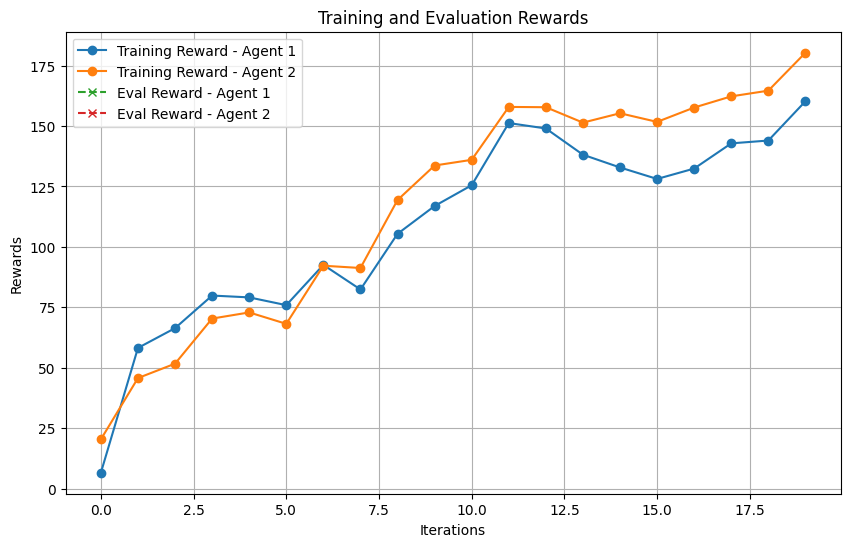

In [ ]:
# Initialize lists for tracking mean rewards and evaluation returns
mean_returns_1 = []
mean_returns_2 = []
eval_returns_1 = []
eval_returns_2 = []

# Training loop
for i in range(20):
    result = algo.train()

    # Get training rewards
    mean_return_agent_1 = result["env_runners"]["agent_episode_returns_mean"].get("agent_1", 0)
    mean_return_agent_2 = result["env_runners"]["agent_episode_returns_mean"].get("agent_2", 0)

    mean_returns_1.append(mean_return_agent_1)
    mean_returns_2.append(mean_return_agent_2)

    print(f"Iter: {i}, Mean Reward agent 1: {mean_return_agent_1}")
    print(f"Iter: {i}, Mean Reward agent 2: {mean_return_agent_2}")

    # Evaluate the algorithm on one episode
    # eval_return_1, eval_return_2 = evaluate_algorithm(algo, env_config={"size": env_config.get("size"), "max_steps": env_config.get("max_steps")})
    # eval_returns_1.append(eval_return_1)
    # eval_returns_2.append(eval_return_2)

# Plot training and evaluation rewards
plt.figure(figsize=(10, 6))
plt.plot(range(len(mean_returns_1)), mean_returns_1, marker="o", label="Training Reward - Agent 1")
plt.plot(range(len(mean_returns_2)), mean_returns_2, marker="o", label="Training Reward - Agent 2")
plt.plot(range(len(eval_returns_1)), eval_returns_1, marker="x", linestyle="--", label="Eval Reward - Agent 1")
plt.plot(range(len(eval_returns_2)), eval_returns_2, marker="x", linestyle="--", label="Eval Reward - Agent 2")
plt.xlabel("Iterations")
plt.ylabel("Rewards")
plt.title("Training and Evaluation Rewards")
plt.legend()
plt.grid()
plt.show()


In [19]:
evaluate_algorithm(algo, env_config={"size": env_config.get("size"), "max_steps": env_config.get("max_steps")}, render_mode= "human", record_video=False, video_folder="videos_multi_agent/")


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x19 and 27x256)

In [19]:
eval_env.close()

## MultiGrid 

In [ ]:


class RLlibWrapper(gym.Wrapper, MultiAgentEnv):
    """
    Wrapper for a ``MultiGridEnv`` environment that implements the
    RLlib ``MultiAgentEnv`` interface.
    """

    def __init__(self, env: MultiGridEnv):
        self._obs_space_in_preferred_format = True
        self._action_space_in_preferred_format = True
        print("base agents: ", env.observation_space)
        gym.Wrapper.__init__(self, env)
        MultiAgentEnv.__init__(self)
        self.observation_spaces = self.env.observation_space
        self.action_spaces = self.env.action_space
        print("we are in the rllib wrapper")
        print('rllib agents: ', self.agents)

    def get_agent_ids(self):
        
        return {agent.index for agent in self.agents}

    def step(self, *args, **kwargs):
        obs, rewards, terminations, truncations, infos = super().step(*args, **kwargs)
        terminations['__all__'] = all(terminations.values())
        truncations['__all__'] = all(truncations.values())
        return obs, rewards, terminations, truncations, infos
    
    




NameError: name 'MultiGridEnv' is not defined

In [ ]:


class CustomMultiGridObsWrapper(gym.core.ObservationWrapper):
    """
    Wrapper pour aplatir les observations des agents et supprimer les missions.
    Fonctionne pour les environnements MultiGrid avec des observations sous forme de dictionnaires.
    """

    def __init__(self, env):
        super().__init__(env)
        # Créer un nouvel espace d'observation sans la mission et avec des observations aplaties
        self.observation_space = Dict({
            agent_id: Box(
                low=0,
                high=255,  # Plage de valeurs pour les pixels d'image
                shape=(np.prod(space["image"].shape) + 1,),  # Inclut direction aplatie
                dtype=np.float32
            )
            for agent_id, space in env.observation_space.spaces.items()
        })

    def observation(self, obs):
        """
        Transforme les observations des agents.
        - Aplatie l'image.
        - Ajoute la direction comme une valeur scalaire.
        - Supprime la mission.
        """
        transformed_obs = {}
        for agent_id, agent_obs in obs.items():
            # Aplatir l'image et ajouter la direction
            flat_image = agent_obs["image"].flatten().astype(np.float32)
            direction = np.array([agent_obs["direction"]], dtype=np.float32)
            transformed_obs[agent_id] = np.concatenate([flat_image, direction])
        print(f"Transformed observation for all agents: {transformed_obs[0].shape}")

        return transformed_obs



In [11]:

def multi_grid_env_creator(config):
    
    render_mode = config.get("render_mode", "human")  # Extraire render_mode du dictionnaire config
    agents = config.get("agents", 2)  # Nombre d'agents par défaut
    
    base_env = gym.make("MultiGrid-Empty-6x6-v0", agents = agents, render_mode=render_mode)
    custom_wrapped_env = CustomMultiGridObsWrapper(base_env)
    rllib_wrapped_env = RLlibWrapper(custom_wrapped_env)

    return rllib_wrapped_env

# Étape 2 : Enregistrer l'environnement avec RLlib
register_env("Multigrid-custom-6x6-v0", multi_grid_env_creator)



In [12]:

env = multi_grid_env_creator({"agents": 2})  # Créez l'environnement
obs, info = env.reset()  # Réinitialisez l'environnement
env.close()
env.render_mode


we are here:  2
base agents:  Dict(0: Box(0.0, 255.0, (148,), float32), 1: Box(0.0, 255.0, (148,), float32))
we are in the rllib wrapper
rllib agents:  []
Transformed observation for all agents: (148,)


'human'

In [2]:


class MultiGridRLlibWrapper(MultiAgentEnv):
    """
    Wrapper for a MultiGridEnv environment that implements the RLlib MultiAgentEnv interface
    and flattens observations for easier processing.
    """

    def __init__(self, env: MultiGridEnv):
        # Initialize as MultiAgentEnv first
        MultiAgentEnv.__init__(self)

        # Store the original environment
        self.env = env

        # Create observation spaces
        self.observation_spaces = Dict({
            agent_id: Box(
                low=0,
                high=255,
                shape=(np.prod(space["image"].shape) + 1,),
                dtype=np.float32
            )
            for agent_id, space in env.observation_space.spaces.items()
        })

        # Create action spaces
        self.action_spaces = env.action_space

        # Multiagent-specific attributes
        self._agent_ids = {agent.index for agent in env.agents}
        
        print("MultiGrid RLlib Wrapper Initialized")
        print("Observation Spaces:", self.observation_spaces)
        print("Action Spaces:", self.action_spaces)

    def get_agent_ids(self):
        """
        Return a set of all agent IDs in the environment.
        """
        return self._agent_ids

    def step(self, action_dict):
        """
        Custom step method that handles multi-agent actions and observations.
        """
        # Convert action_dict to a format the environment understands
        actions = [action_dict.get(agent_index, None) for agent_index in self._agent_ids]
        
        # Perform environment step
        obs, rewards, terminations, truncations, infos = self.env.step(actions)
        
        # Flatten observations
        flattened_obs = {}
        for agent_id, agent_obs in obs.items():
            flat_image = agent_obs["image"].flatten().astype(np.float32)
            direction = np.array([agent_obs["direction"]], dtype=np.float32)
            flattened_obs[agent_id] = np.concatenate([flat_image, direction])
        
        # Add special '__all__' termination and truncation keys
        terminations['__all__'] = all(terminations.values())
        truncations['__all__'] = all(truncations.values())
        
        return flattened_obs, rewards, terminations, truncations, infos

    def reset(self, seed=None, options=None):
        """
        Reset the environment and return initial observations.
        """
        obs, info = self.env.reset(seed=seed, options=options)
        
        # Flatten initial observations
        flattened_obs = {}
        for agent_id, agent_obs in obs.items():
            flat_image = agent_obs["image"].flatten().astype(np.float32)
            direction = np.array([agent_obs["direction"]], dtype=np.float32)
            flattened_obs[agent_id] = np.concatenate([flat_image, direction])
        
        return flattened_obs, info

    def render(self):
        """
        Render the environment.
        """
        return self.env.render()

In [3]:
def env_creator(env_config):
    # Create the base MultiGrid environment
    env = multigrid.envs.empty.EmptyEnv(**env_config)
    
    # Wrap it with the MultiAgentEnv wrapper
    multi_agent_env = MultiGridRLlibWrapper(env)
    
    return multi_agent_env


In [4]:
def new_env_creator(env_config):
    """
    Create a new MultiGridRLlibWrapper environment.
    """
    render_mode = env_config.get("render_mode", "human")
    agents = env_config.get("agents", 2)
    
    base_env = gym.make("MultiGrid-Empty-6x6-v0", agents=agents, render_mode=render_mode)
    rllib_wrapped_env = MultiGridRLlibWrapper(base_env)
    
    return rllib_wrapped_env

register_env("Multigrid-custom-6x6-v0", env_creator)


In [5]:
def policy_mapping_fn_multigrid(agent_id, episode=None):
    """
    Maps agent_id to a policy.
    """
    if agent_id == 0:
        return "agent_1"
    if agent_id == 1:
        return "agent_2"
    else:
        raise ValueError(f"Unknown agent_id: {agent_id}")


In [6]:
env = env_creator({"agents": 2}) 
env.reset()
env.agents

we are here:  2
MultiGrid RLlib Wrapper Initialized
Observation Spaces: Dict(0: Box(0.0, 255.0, (148,), float32), 1: Box(0.0, 255.0, (148,), float32))
Action Spaces: Dict(0: Discrete(7), 1: Discrete(7))


[]

In [7]:
config = (
    PPOConfig()
    .environment(env="Multigrid-custom-6x6-v0")
    .training(train_batch_size_per_learner=600)
    .api_stack(
        enable_rl_module_and_learner=True,
        enable_env_runner_and_connector_v2=True,
    )
    .framework("torch")
    .multi_agent(
        policies={
            "agent_1": PolicySpec(
                policy_class=None,  # Inférer automatiquement
                observation_space=None,  # Inférer automatiquement depuis l'environnement
                action_space=None,  # Inférer automatiquement depuis l'environnement
                config=None,  # Utiliser la configuration par défaut
            ),
            "agent_2": PolicySpec(
                policy_class=None,  # Inférer automatiquement
                observation_space=None,  # Inférer automatiquement depuis l'environnement
                action_space=None,  # Inférer automatiquement depuis l'environnement
                config=None,  # Utiliser la configuration par défaut
            ),
        },
        policy_mapping_fn=policy_mapping_fn_multigrid,
    )
)

algo = config.build()


2024-12-11 20:21:02,318	WARNING ppo.py:295 -- You are running PPO on the new API stack! This is the new default behavior for this algorithm. If you don't want to use the new API stack, set `config.api_stack(enable_rl_module_and_learner=False,enable_env_runner_and_connector_v2=False)`. For a detailed migration guide, see here: https://docs.ray.io/en/master/rllib/new-api-stack-migration-guide.html
c:\Users\idris\AppData\Local\Programs\Python\Python310\lib\site-packages\ray\rllib\algorithms\algorithm.py:569: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
c:\Users\idris\AppData\Local\Programs\Python\Python310\lib\site-packages\ray\tune\logger\unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could 

(MultiAgentEnvRunner pid=6868) we are here:  1
(MultiAgentEnvRunner pid=6868) MultiGrid RLlib Wrapper Initialized
(MultiAgentEnvRunner pid=6868) Observation Spaces: Dict(0: Box(0.0, 255.0, (148,), float32))
(MultiAgentEnvRunner pid=6868) Action Spaces: Dict(0: Discrete(7))


(MultiAgentEnvRunner pid=6868) 2024-12-11 20:21:10,949	ERROR multi_agent_env_runner.py:858 -- The element returned by reset() has agent_ids that are not the names of the agents in the env. 
(MultiAgentEnvRunner pid=6868) AgentIDs in this MultiAgentDict: [0]
(MultiAgentEnvRunner pid=6868) AgentIDs in this env: []. You likely need to add the attribute `agents` to your env, which is a list containing the IDs of agents currently in your env/episode, as well as, `possible_agents`, which is a list of all possible agents that could ever show up in your env.
(MultiAgentEnvRunner pid=6868) Traceback (most recent call last):
(MultiAgentEnvRunner pid=6868)   File "c:\Users\idris\AppData\Local\Programs\Python\Python310\lib\site-packages\ray\rllib\env\multi_agent_env_runner.py", line 856, in make_env
(MultiAgentEnvRunner pid=6868)     check_multiagent_environments(self.env.unwrapped)
(MultiAgentEnvRunner pid=6868)   File "c:\Users\idris\AppData\Local\Programs\Python\Python310\lib\site-packages\ray\

we are here:  1
MultiGrid RLlib Wrapper Initialized
Observation Spaces: Dict(0: Box(0.0, 255.0, (148,), float32))
Action Spaces: Dict(0: Discrete(7))


StopIteration: 

In [55]:
env.close()